In [1]:
import melanoma as mel

%matplotlib inline
%load_ext autoreload
%autoreload -p 2

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

rootpath = '/hpcstor6/scratch01/s/sanghyuk.kim001'
img_size = (112, 150) # height, width
utilInstance = mel.Util(rootpath, img_size)
dataType = mel.DatasetType.ISIC2017


DEBUG = 0
# Save datasets as pickle files
if (DEBUG == 1):
    utilInstance.saveDatasetsToFile(dataType)

dbpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/melanomaDB/customDB'

trainimages_HAM10000, testimages_HAM10000, validationimages_HAM10000, \
			trainlabels_binary_HAM10000, testlabels_binary_HAM10000, validationlabels_binary_HAM10000, num_classes_binary_HAM10000\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+f'HAM10000_{img_size[0]}h_{img_size[1]}w_binary.pkl')
trainimages_ISIC2016, testimages_ISIC2016, validationimages_ISIC2016, \
			trainlabels_binary_ISIC2016, testlabels_binary_ISIC2016, validationlabels_binary_ISIC2016, num_classes_binary_ISIC2016\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+f'ISIC2016_{img_size[0]}h_{img_size[1]}w_binary.pkl')
trainimages_ISIC2017, testimages_ISIC2017, validationimages_ISIC2017, \
			trainlabels_binary_ISIC2017, testlabels_binary_ISIC2017, validationlabels_binary_ISIC2017, num_classes_binary_ISIC2017\
                 = utilInstance.loadDatasetFromFile(dbpath+'/'+f'ISIC2017_{img_size[0]}h_{img_size[1]}w_binary.pkl')



img_height, img_width = utilInstance.getImgSize()
CFG = dict(
			batch_size            =  20,   # 8; 16; 32; 64; bigger batch size => moemry allocation issue
			epochs                =  30,   # 5; 10; 20;
			last_trainable_layers =   0,
			verbose               =   1,   # 0; 1
			fontsize              =  14,
			num_classes           =  2, # binary

			# Images sizes
			img_height = img_height,   # Original: (450h, 600w)
            img_width = img_width,

			# Images augs
			ROTATION_RANGE        =  90.0,
			ZOOM_RANGE            =   0.1,
			HSHIFT_RANGE          =   0.1, # randomly shift images horizontally
			WSHIFT_RANGE          =   0.1, # randomly shift images vertically
			HFLIP                 = False, # randomly flip images
			VFLIP                 = False, # randomly flip images

			# Postprocessing
			stopper_patience      =  10,   # 0.01; 0.05; 0.1; 0.2;
			run_functions_eagerly = False,
            
            # save
            snapshot_path = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot'
		)

2023-12-09 14:38:29.980170: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2023-12-09 14:38:49.764114: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-12-09 14:38:49.895311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-12-09 14:38:49.895347: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-12-09 14:38:49.945789: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-12-09 14:38:49.945826: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-12-09 14:38:49.965026: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Building HAM10000 binary training on ResNet50 model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
_________________________________________________________________
None
Fitting HAM10000 binary training on ResNet50

2023-12-09 14:38:53.781572: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-12-09 14:38:53.800749: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245800000 Hz


Epoch 1/30


2023-12-09 14:38:56.151124: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-12-09 14:38:57.447476: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-12-09 14:38:59.649370: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-12-09 14:38:59.649392: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-12-09 14:38:59.650445: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-09 14:38:59.722991: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-12-09 14:39:02.004643: I tensorflow/stream_exec

  3/401 [..............................] - ETA: 27s - loss: 6.7786 - accuracy: 0.4167   

2023-12-09 14:39:03.213541: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


401/401 [==============================] - 42s 82ms/step - loss: 4.0299 - accuracy: 0.8249 - val_loss: 2.7050 - val_accuracy: 0.9468


/home/sanghyuk.kim001/anaconda3/envs/clean_chimera_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
401/401 [==============================] - 30s 75ms/step - loss: 2.3856 - accuracy: 0.8633 - val_loss: 1.7883 - val_accuracy: 0.9468
Epoch 3/30
401/401 [==============================] - 30s 75ms/step - loss: 1.6777 - accuracy: 0.8695 - val_loss: 1.2924 - val_accuracy: 0.9445
Epoch 4/30
401/401 [==============================] - 30s 75ms/step - loss: 1.2689 - accuracy: 0.8701 - val_loss: 0.9803 - val_accuracy: 0.9434
Epoch 5/30
401/401 [==============================] - 30s 75ms/step - loss: 1.0023 - accuracy: 0.8763 - val_loss: 0.7786 - val_accuracy: 0.9502
Epoch 6/30
401/401 [==============================] - 30s 75ms/step - loss: 0.8286 - accuracy: 0.8739 - val_loss: 0.6051 - val_accuracy: 0.9490
Epoch 7/30
401/401 [==============================] - 30s 75ms/step - loss: 0.7028 - accuracy: 0.8754 - val_loss: 0.5160 - val_accuracy: 0.9456
Epoch 8/30
401/401 [==============================] - 30s 75ms/step - loss: 0.6123 - accuracy: 0.8788 - val_loss: 0.4397 - val_accuracy:

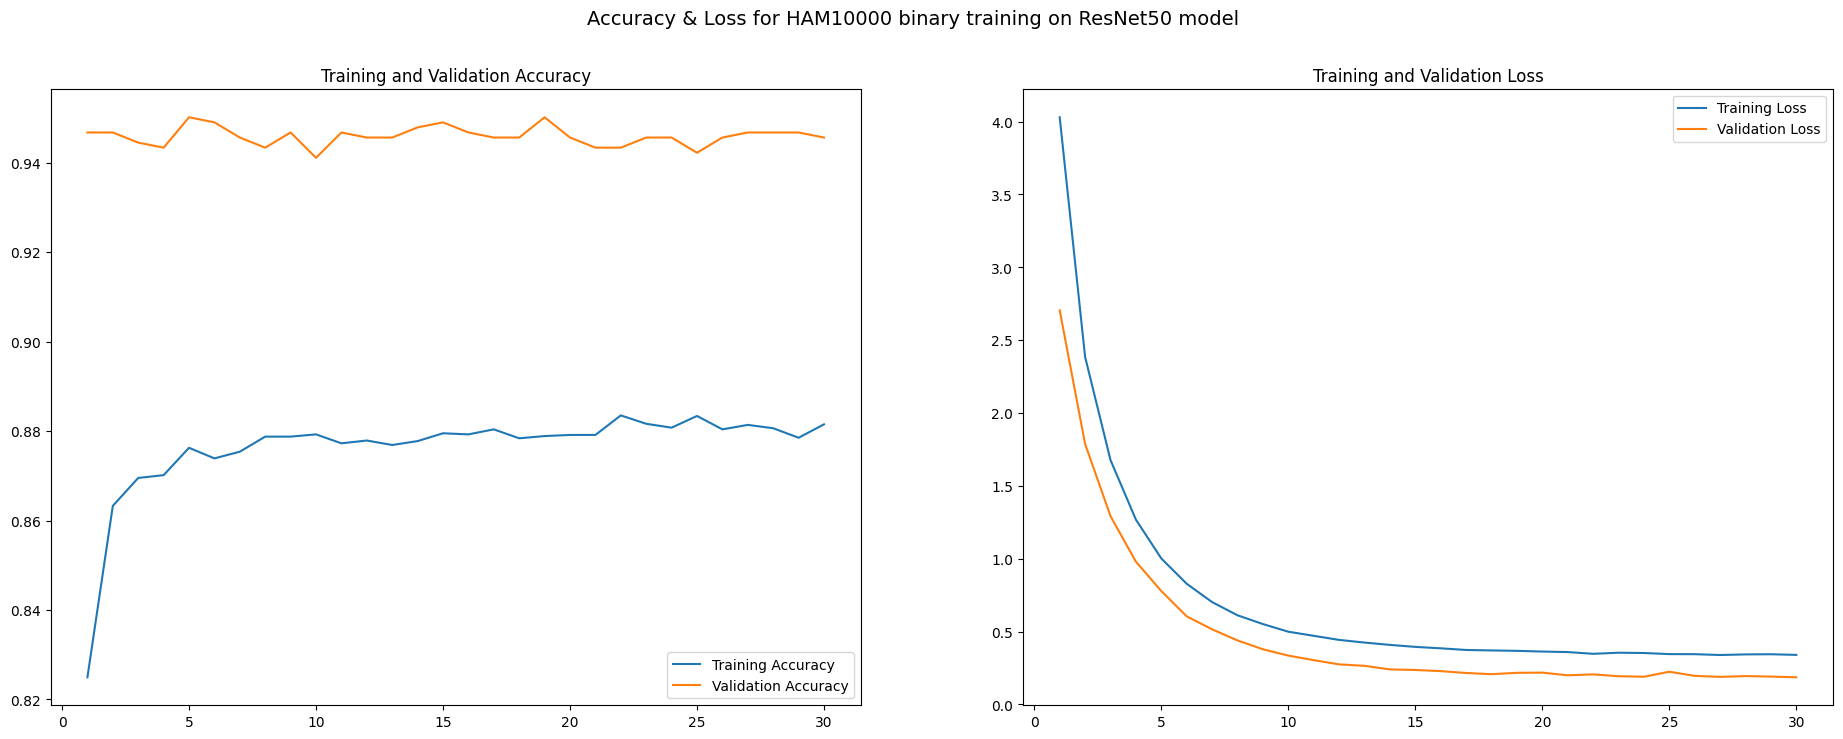

In [2]:
# Solely training HAM10000

base_model_binary = mel.CNN(trainimages_HAM10000, trainlabels_binary_HAM10000, \
    validationimages_HAM10000, validationlabels_binary_HAM10000, \
        testimages_HAM10000, testlabels_binary_HAM10000, CFG)
ResNet50_name = 'HAM10000 binary training on ResNet50'
data_gen_HAM10000, Resnet50_model = base_model_binary.resnet50(ResNet50_name)

# Install the below beforehand
# pip install pydot
# conda install -c anaconda graphviz
visualizer = mel.Visualizer()
visualizer.visualize_model(model = Resnet50_model, model_name = ResNet50_name)

# Train HAM10000
history_HAM10000_bin = base_model_binary.fit_model(    
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages_HAM10000,
    trainlabels = trainlabels_binary_HAM10000,
    validationimages = validationimages_HAM10000,
    validationlabels = validationlabels_binary_HAM10000,
    data_gen = data_gen_HAM10000
)

visualizer.visualize_performance(
    model_name = ResNet50_name,
    history = history_HAM10000_bin
)

Input 0: HAM10000 train images
Input 1: ISIC2016 train images
Combined images: HAM10000 train images AND ISIC2016 train images AND 
Input 0: HAM10000 test images
Input 1: ISIC2016 test images
Combined images: HAM10000 test images AND ISIC2016 test images AND 
Input 0: HAM10000 validation images
Input 1: ISIC2016 validation images
Combined images: HAM10000 validation images AND ISIC2016 validation images AND 
Input: 0: HAM10000 train labels
Input: 1: ISIC2016 train labels
Combined labels: HAM10000 train labels AND ISIC2016 train labels AND 
Input: 0: HAM10000 test labels
Input: 1: ISIC2016 test labels
Combined labels: HAM10000 test labels AND ISIC2016 test labels AND 
Input: 0: HAM10000 validation labels
Input: 1: ISIC2016 validation labels
Combined labels: HAM10000 validation labels AND ISIC2016 validation labels AND 
Building HAM10000 + ISIC2016 binary training on ResNet50 model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)    

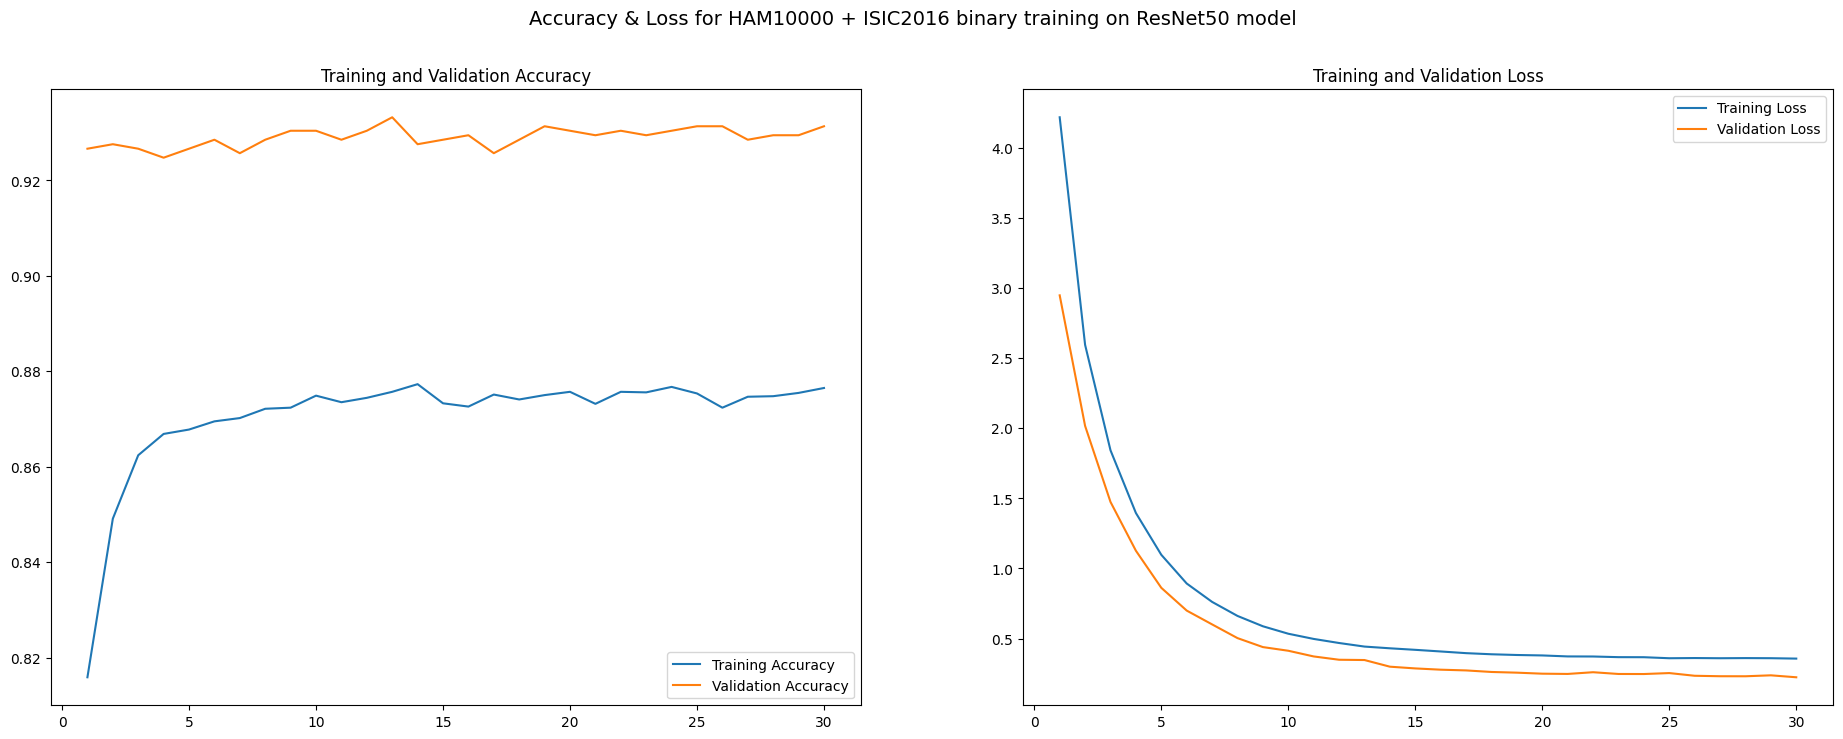

In [3]:
# HAM10000 + ISIC2016 binary training

# Now, let's combine HAM10000 and ISIC2016 DBs
trainimages_combination = {"HAM10000 train images":trainimages_HAM10000, "ISIC2016 train images":trainimages_ISIC2016}
testimages_combination = {"HAM10000 test images":testimages_HAM10000, "ISIC2016 test images":testimages_ISIC2016}
validationimages_combination = {"HAM10000 validation images":validationimages_HAM10000, "ISIC2016 validation images":validationimages_ISIC2016}
trainlabels_combination = {"HAM10000 train labels":trainlabels_binary_HAM10000, "ISIC2016 train labels":trainlabels_binary_ISIC2016}
testlabels_combination = {"HAM10000 test labels":testlabels_binary_HAM10000, "ISIC2016 test labels":testlabels_binary_ISIC2016}
validationlabels_combination = {"HAM10000 validation labels":validationlabels_binary_HAM10000, "ISIC2016 validation labels":validationlabels_binary_ISIC2016}

trainimages_HAM10000_ISIC2016 = utilInstance.combine_images(**trainimages_combination)
testimages_HAM10000_ISIC2016 = utilInstance.combine_images(**testimages_combination)
validationimages_HAM10000_ISIC2016 = utilInstance.combine_images(**validationimages_combination)
trainlabels_binary_HAM10000_ISIC2016 = utilInstance.combine_labels(**trainlabels_combination)
testlabels_binary_HAM10000_ISIC2016 = utilInstance.combine_labels(**testlabels_combination)
validationlabels_binary_HAM10000_ISIC2016 = utilInstance.combine_labels(**validationlabels_combination)


base_model_binary = mel.CNN(trainimages_HAM10000_ISIC2016, trainlabels_binary_HAM10000_ISIC2016, \
    validationimages_HAM10000_ISIC2016, validationlabels_binary_HAM10000_ISIC2016, \
        testimages_HAM10000_ISIC2016, testlabels_binary_HAM10000_ISIC2016, CFG)
ResNet50_name = 'HAM10000 + ISIC2016 binary training on ResNet50'
data_gen_HAM10000_ISIC2016, Resnet50_model = base_model_binary.resnet50(ResNet50_name)

# Install the below beforehand
# pip install pydot
# conda install -c anaconda graphviz
visualizer = mel.Visualizer()
visualizer.visualize_model(model = Resnet50_model, model_name = ResNet50_name)

# Train HAM10000 + ISIC2016
history_HAM10000_ISIC2016_bin = base_model_binary.fit_model(    
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages_HAM10000_ISIC2016,
    trainlabels = trainlabels_binary_HAM10000_ISIC2016,
    validationimages = validationimages_HAM10000_ISIC2016,
    validationlabels = validationlabels_binary_HAM10000_ISIC2016,
    data_gen = data_gen_HAM10000_ISIC2016
)

visualizer.visualize_performance(
    model_name = ResNet50_name,
    history = history_HAM10000_ISIC2016_bin
)

Input 0: HAM10000 train images
Input 1: ISIC2016 train images
Input 2: ISIC2017 train images
Combined images: HAM10000 train images AND ISIC2016 train images AND ISIC2017 train images AND 
Input 0: HAM10000 test images
Input 1: ISIC2016 test images
Input 2: ISIC2017 test images
Combined images: HAM10000 test images AND ISIC2016 test images AND ISIC2017 test images AND 
Input 0: HAM10000 validation images
Input 1: ISIC2016 validation images
Input 2: ISIC2017 validation images
Combined images: HAM10000 validation images AND ISIC2016 validation images AND ISIC2017 validation images AND 
Input: 0: HAM10000 train labels
Input: 1: ISIC2016 train labels
Input: 2: ISIC2017 train labels
Combined labels: HAM10000 train labels AND ISIC2016 train labels AND ISIC2017 train labels AND 
Input: 0: HAM10000 test labels
Input: 1: ISIC2016 test labels
Input: 2: ISIC2017 test labels
Combined labels: HAM10000 test labels AND ISIC2016 test labels AND ISIC2017 test labels AND 
Input: 0: HAM10000 validation l

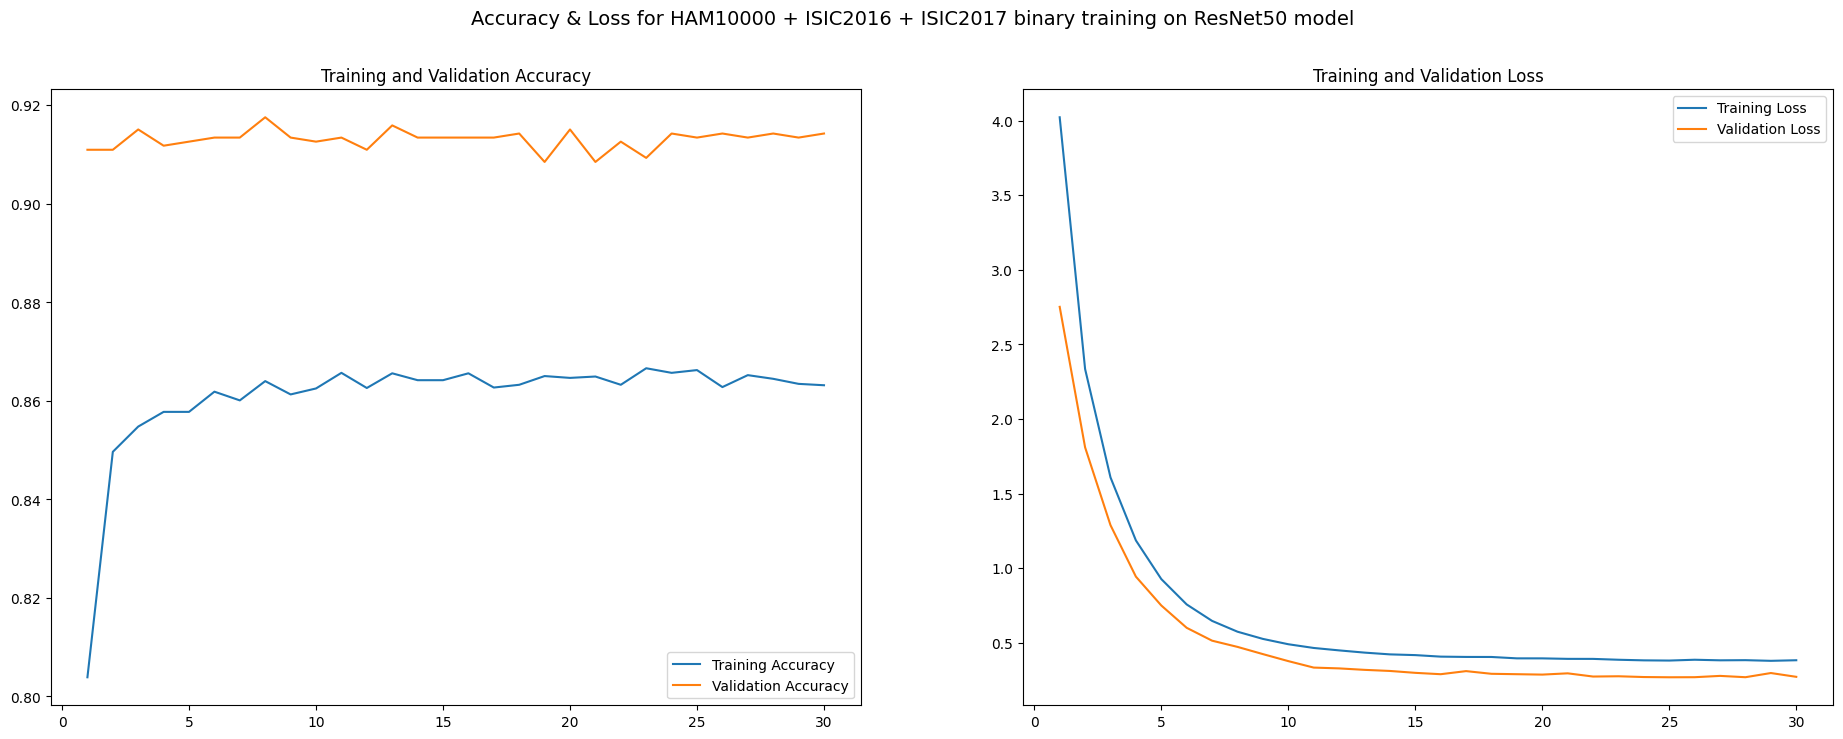

In [4]:
# HAM10000 + ISIC2016 + ISIC2017 binary training

# Now, let's combine HAM10000, ISIC2016 and ISIC2017
trainimages_combination = {"HAM10000 train images":trainimages_HAM10000, "ISIC2016 train images":trainimages_ISIC2016, "ISIC2017 train images":trainimages_ISIC2017}
testimages_combination = {"HAM10000 test images":testimages_HAM10000, "ISIC2016 test images":testimages_ISIC2016, "ISIC2017 test images":testimages_ISIC2017}
validationimages_combination = {"HAM10000 validation images":validationimages_HAM10000, "ISIC2016 validation images":validationimages_ISIC2016, "ISIC2017 validation images":validationimages_ISIC2017}
trainlabels_combination = {"HAM10000 train labels":trainlabels_binary_HAM10000, "ISIC2016 train labels":trainlabels_binary_ISIC2016, "ISIC2017 train labels":trainlabels_binary_ISIC2017}
testlabels_combination = {"HAM10000 test labels":testlabels_binary_HAM10000, "ISIC2016 test labels":testlabels_binary_ISIC2016, "ISIC2017 test labels":testlabels_binary_ISIC2017}
validationlabels_combination = {"HAM10000 validation labels":validationlabels_binary_HAM10000, "ISIC2016 validation labels":validationlabels_binary_ISIC2016, "ISIC2017 validation labels":validationlabels_binary_ISIC2017}

trainimages_HAM10000_ISIC2016_ISIC2017 = utilInstance.combine_images(**trainimages_combination)
testimages_HAM10000_ISIC2016_ISIC2017 = utilInstance.combine_images(**testimages_combination)
validationimages_HAM10000_ISIC2016_ISIC2017 = utilInstance.combine_images(**validationimages_combination)
trainlabels_binary_HAM10000_ISIC2016_ISIC2017 = utilInstance.combine_labels(**trainlabels_combination)
testlabels_binary_HAM10000_ISIC2016_ISIC2017 = utilInstance.combine_labels(**testlabels_combination)
validationlabels_binary_HAM10000_ISIC2016_ISIC2017 = utilInstance.combine_labels(**validationlabels_combination)


base_model_binary = mel.CNN(trainimages_HAM10000_ISIC2016_ISIC2017, trainlabels_binary_HAM10000_ISIC2016_ISIC2017, \
    validationimages_HAM10000_ISIC2016_ISIC2017, validationlabels_binary_HAM10000_ISIC2016_ISIC2017, \
        testimages_HAM10000_ISIC2016_ISIC2017, testlabels_binary_HAM10000_ISIC2016_ISIC2017, CFG)
ResNet50_name = 'HAM10000 + ISIC2016 + ISIC2017 binary training on ResNet50'
data_gen_HAM10000_ISIC2016_ISIC2017, Resnet50_model = base_model_binary.resnet50(ResNet50_name)

# Install the below beforehand
# pip install pydot
# conda install -c anaconda graphviz
visualizer = mel.Visualizer()
visualizer.visualize_model(model = Resnet50_model, model_name = ResNet50_name)

# Train HAM10000 + ISIC2016 + ISIC2017
history_HAM10000_ISIC2016_ISIC2017_bin = base_model_binary.fit_model(    
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages_HAM10000_ISIC2016_ISIC2017,
    trainlabels = trainlabels_binary_HAM10000_ISIC2016_ISIC2017,
    validationimages = validationimages_HAM10000_ISIC2016_ISIC2017,
    validationlabels = validationlabels_binary_HAM10000_ISIC2016_ISIC2017,
    data_gen = data_gen_HAM10000_ISIC2016_ISIC2017
)

visualizer.visualize_performance(
    model_name = ResNet50_name,
    history = history_HAM10000_ISIC2016_ISIC2017_bin
)

In [5]:
# Testing HAM10000 trained model

from keras.models import load_model
# modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/'
filename = 'HAM10000 binary training on ResNet50.hdf5'
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename
# saved_model = load_model(modelpath)


# Test set should be using only ISIC2016 or ISIC2017 test sets
# Test on ISIC 2016 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2016,
    trainlabels = trainlabels_binary_ISIC2016,
    validationimages = validationimages_ISIC2016,
    validationlabels = validationlabels_binary_ISIC2016,
    testimages = testimages_ISIC2016,
    testlabels = testlabels_binary_ISIC2016
)

# Test on ISIC2017 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2017,
    trainlabels = trainlabels_binary_ISIC2017,
    validationimages = validationimages_ISIC2017,
    validationlabels = validationlabels_binary_ISIC2017,
    testimages = testimages_ISIC2017,
    testlabels = testlabels_binary_ISIC2017
)


Evaluating HAM10000 binary ResNet50 model...

23/23 [==============================] - 2s 41ms/step - loss: 0.5087 - accuracy: 0.8178
Train loss = 0.5086572170257568  ;  Train accuracy = 81.78%

6/6 [==============================] - 0s 16ms/step - loss: 0.4468 - accuracy: 0.8389
Validation loss = 0.4467586874961853  ;  Validation accuracy = 83.89%

12/12 [==============================] - 1s 69ms/step - loss: 0.4805 - accuracy: 0.8148
Test loss = 0.48047319054603577  ;  Test accuracy = 81.48%
Evaluating HAM10000 binary ResNet50 model...

63/63 [==============================] - 2s 25ms/step - loss: 0.5159 - accuracy: 0.8210
Train loss = 0.5159361362457275  ;  Train accuracy = 82.10%

5/5 [==============================] - 1s 157ms/step - loss: 0.5731 - accuracy: 0.8067
Validation loss = 0.5731201171875  ;  Validation accuracy = 80.67%

19/19 [==============================] - 1s 48ms/step - loss: 0.5774 - accuracy: 0.8083
Test loss = 0.5773760080337524  ;  Test accuracy = 80.83%


In [6]:
# Testing HAM10000 + ISIC2016 trained model

from keras.models import load_model
# modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/'
filename = 'HAM10000 + ISIC2016 binary training on ResNet50.hdf5'
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename
# saved_model = load_model(modelpath)


# Test set should be using only ISIC2016 or ISIC2017 test sets
# Test on ISIC2016 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 + ISIC2016 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2016,
    trainlabels = trainlabels_binary_ISIC2016,
    validationimages = validationimages_ISIC2016,
    validationlabels = validationlabels_binary_ISIC2016,
    testimages = testimages_ISIC2016,
    testlabels = testlabels_binary_ISIC2016
)

# Test on ISIC2017 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 + ISIC2016 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2017,
    trainlabels = trainlabels_binary_ISIC2017,
    validationimages = validationimages_ISIC2017,
    validationlabels = validationlabels_binary_ISIC2017,
    testimages = testimages_ISIC2017,
    testlabels = testlabels_binary_ISIC2017
)


Evaluating HAM10000 + ISIC2016 binary ResNet50 model...

23/23 [==============================] - 1s 16ms/step - loss: 0.4950 - accuracy: 0.8150
Train loss = 0.494974285364151  ;  Train accuracy = 81.50%

6/6 [==============================] - 0s 16ms/step - loss: 0.4399 - accuracy: 0.8444
Validation loss = 0.4398719370365143  ;  Validation accuracy = 84.44%

12/12 [==============================] - 0s 16ms/step - loss: 0.4758 - accuracy: 0.8122
Test loss = 0.47580263018608093  ;  Test accuracy = 81.22%
Evaluating HAM10000 + ISIC2016 binary ResNet50 model...

63/63 [==============================] - 2s 16ms/step - loss: 0.5252 - accuracy: 0.8210
Train loss = 0.5251652598381042  ;  Train accuracy = 82.10%

5/5 [==============================] - 0s 16ms/step - loss: 0.5906 - accuracy: 0.8000
Validation loss = 0.5905858278274536  ;  Validation accuracy = 80.00%

19/19 [==============================] - 0s 16ms/step - loss: 0.6316 - accuracy: 0.8050
Test loss = 0.631613552570343  ;  Test a

In [7]:
# Testing HAM10000 + ISIC2016 + ISIC2017 trained model

from keras.models import load_model
# modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/'
filename = 'HAM10000 + ISIC2016 + ISIC2017 binary training on ResNet50.hdf5'
modelpath = '/hpcstor6/scratch01/s/sanghyuk.kim001/snapshot/' + filename
# saved_model = load_model(modelpath)


# Test set should be using only ISIC2016 or ISIC2017 test sets
# Test on ISIC2016 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 + ISIC2016 + ISIC2017 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2016,
    trainlabels = trainlabels_binary_ISIC2016,
    validationimages = validationimages_ISIC2016,
    validationlabels = validationlabels_binary_ISIC2016,
    testimages = testimages_ISIC2016,
    testlabels = testlabels_binary_ISIC2016
)

# Test on ISIC2017 test set
Resnet50_model, test_loss, ResNet50_test_acc = base_model_binary.evaluate_model(
    model_name = 'HAM10000 + ISIC2016 + ISIC2017 binary ResNet50',
    model_path = modelpath,
    trainimages = trainimages_ISIC2017,
    trainlabels = trainlabels_binary_ISIC2017,
    validationimages = validationimages_ISIC2017,
    validationlabels = validationlabels_binary_ISIC2017,
    testimages = testimages_ISIC2017,
    testlabels = testlabels_binary_ISIC2017
)


Evaluating HAM10000 + ISIC2016 + ISIC2017 binary ResNet50 model...

23/23 [==============================] - 1s 16ms/step - loss: 0.4573 - accuracy: 0.8248
Train loss = 0.45732441544532776  ;  Train accuracy = 82.48%

6/6 [==============================] - 0s 16ms/step - loss: 0.4034 - accuracy: 0.8556
Validation loss = 0.40339261293411255  ;  Validation accuracy = 85.56%

12/12 [==============================] - 0s 16ms/step - loss: 0.4429 - accuracy: 0.8095
Test loss = 0.44288384914398193  ;  Test accuracy = 80.95%
Evaluating HAM10000 + ISIC2016 + ISIC2017 binary ResNet50 model...

63/63 [==============================] - 2s 16ms/step - loss: 0.4590 - accuracy: 0.8245
Train loss = 0.4590027332305908  ;  Train accuracy = 82.45%

5/5 [==============================] - 0s 17ms/step - loss: 0.4980 - accuracy: 0.8000
Validation loss = 0.4979625344276428  ;  Validation accuracy = 80.00%

19/19 [==============================] - 0s 16ms/step - loss: 0.5128 - accuracy: 0.8050
Test loss = 0.5